# Post-processing for OPF test cases

In this notebook, we will show how to post-process the results of the OPF test cases. The results are stored in the `results` folder. The model runs are in 2018. 

Includes the following scenarios:

1. Base case without renewable generation, stored in `results/wo_renew`.

2. Cases with renewable generation, stored in `results/w_renew`.

3. Cases with renewable generation and building electrification, stored in `results/w_renew_elec`.


## Packages

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import pickle

import nygrid.run_nygrid as ng_run
import nygrid.nygrid as ng_grid
import nygrid.postprocessing as ng_post

# plt.rcParams["font.family"] = "Times New Roman"


In [2]:
# Set up directories
cwd = os.getcwd()
if 'examples' in cwd:
    parent_dir = os.path.dirname(cwd)
    data_dir = os.path.join(parent_dir, 'data')
else:
    data_dir = os.path.join(cwd, 'data')

fig_dir = os.path.join(os.path.dirname(data_dir), 'figures')
print('Figure directory: {}'.format(fig_dir))

results_dir = os.path.join(os.path.dirname(data_dir), 'results')
print('Results directory: {}'.format(results_dir))


Figure directory: /mnt/Bo_HDD/NYgrid-python/figures
Results directory: /mnt/Bo_HDD/NYgrid-python/results


## Read grid data

In [3]:
start_date = datetime(2018, 1, 1, 0, 0, 0)
end_date = datetime(2018, 12, 31, 0, 0, 0)
timestamp_list = pd.date_range(start_date, end_date, freq='1D')

## Read OPF results

### 1. 2018Base

In [4]:
sim_name = '2018NewParams'
leading_hours = 12

grid_data_dir_2018 = os.path.join(data_dir, 'grid', '2018NewParams')
assert os.path.exists(grid_data_dir_2018), f'Grid data directory not found: {grid_data_dir_2018}'

# sim_results_dir_2018 = os.path.join(results_dir, '2018Baseline')
sim_results_dir_2018 = os.path.join(results_dir, '2018NewParams')
assert os.path.exists(sim_results_dir_2018), f'Results directory not found: {sim_results_dir_2018}'

# Read load and generation profiles
grid_prop_2018 = ng_run.read_grid_prop(grid_data_dir_2018)
display(grid_prop_2018.keys())

grid_profile_2018 = ng_run.read_grid_profile(grid_data_dir_2018, year=2018)
display(grid_profile_2018.keys())

# Generator fuel types
display(grid_prop_2018['gen_fuel']['GEN_FUEL'].unique())

# Create NYGrid object
start_datetime_0 = timestamp_list[0]
end_datetime_0 = start_datetime_0 + timedelta(hours=24*364+23)
nygrid_sim_2018 = ng_grid.NYGrid(grid_prop=grid_prop_2018,
                                 start_datetime=start_datetime_0,
                                 end_datetime=end_datetime_0,
                                 verbose=False)
print(f"Number of generators: {nygrid_sim_2018.NG}")
print(f"Number of HVDC lines: {nygrid_sim_2018.NDCL}")
print(f"Number of VRE generators: {nygrid_sim_2018.NVRE}")
print(f"Number of ESR units: {nygrid_sim_2018.NESR}")
print(f"Number of buses and branches: {nygrid_sim_2018.NB} and {nygrid_sim_2018.NBR}")
print(f"Number of loads: {nygrid_sim_2018.NL}")
print(f"Number of time periods: {nygrid_sim_2018.NT}")

dict_keys(['bus_prop', 'gen_prop', 'gen_fuel', 'gencost_prop', 'branch_prop', 'if_lim_prop', 'if_map_prop', 'esr_prop', 'dcline_prop'])

dict_keys(['load_profile', 'genmax_profile', 'gencost0_profile', 'gencost1_profile', 'gencost_startup_profile'])

array(['ST_NG', 'CT_NG', 'CC_NG', 'CT_FO2', 'CT_KER', 'ST_FO6', 'ST_BIT',
       'NU_UR', 'HY_WAT', 'Import_Import', 'WT_WND', 'PV_SUN',
       'Other_Other'], dtype=object)

Number of generators: 337
Number of HVDC lines: 4
Number of VRE generators: 0
Number of ESR units: 8
Number of buses and branches: 57 and 94
Number of loads: 57
Number of time periods: 8760


In [5]:
# Read results
filename = f'nygrid_sim_{sim_name}_2018_yearly.pkl'
with open(os.path.join(results_dir, sim_name, filename), 'rb') as f:
    results = pickle.load(f)

In [6]:
# Power dispatch of generators by fuel type
# Including ESR, DC line, and VRE
pg_by_fuel_dict_2018 = ng_post.get_pg_by_fuel(results, nygrid_sim_2018,
                                              valid_hours=nygrid_sim_2018.NT)

# ESR results, including discharge and charge power, and SOC
esr_results_2018 = ng_post.get_esr_results(results, nygrid_sim_2018,
                                           valid_hours=nygrid_sim_2018.NT)

# # LMP by bus and by zone
# # lmp_results_2018 = ng_post.get_lmp_results(results, nygrid_sim_2018)

# Branch flow and interface flow results
flow_results_2018 = ng_post.get_flow_results(results, nygrid_sim_2018,
                                             valid_hours=nygrid_sim_2018.NT)

# Costs
cost_results_2018 = ng_post.get_cost_results(results, nygrid_sim_2018,
                                             valid_hours=nygrid_sim_2018.NT)

# Slack variables and penalty costs
slack_results_2018 = ng_post.get_slack_results(results, nygrid_sim_2018,
                                               valid_hours=nygrid_sim_2018.NT)

### 2. 2030CLCPA

In [7]:
sim_name = '2030CLCPA_0.3'
leading_hours = 12

grid_data_dir_2030 = os.path.join(data_dir, 'grid', '2030CLCPA')
assert os.path.exists(grid_data_dir_2030), f'Grid data directory not found: {grid_data_dir_2030}'

# sim_results_dir_2030 = os.path.join(results_dir, '2030CLCPA_0.3')
sim_results_dir_2030 = os.path.join(results_dir, 'backup_3xcost_uc', '2030CLCPA_0.3')
assert os.path.exists(sim_results_dir_2030), f'Results directory not found: {sim_results_dir_2030}'

# Read load and generation profiles
grid_prop_2030 = ng_run.read_grid_prop(grid_data_dir_2030)
display(grid_prop_2030.keys())

grid_profile_2030 = ng_run.read_grid_profile(grid_data_dir_2030, year=2018)
display(grid_profile_2030.keys())

# Generator fuel types
display(grid_prop_2030['gen_fuel']['GEN_FUEL'].unique())


dict_keys(['bus_prop', 'gen_prop', 'gen_fuel', 'gencost_prop', 'branch_prop', 'if_lim_prop', 'if_map_prop', 'esr_prop', 'dcline_prop'])

dict_keys(['load_profile', 'gen_profile', 'genmax_profile', 'genmin_profile', 'genramp30_profile', 'gencost0_profile', 'gencost1_profile', 'gencost_startup_profile', 'gencost_shutdown_profile'])

array(['Combustion Turbine', 'Combined Cycle', 'Internal Combustion',
       'Steam Turbine', 'Jet Engine', 'Nuclear', 'Hydro', 'Import',
       'Wind', 'Other'], dtype=object)

In [8]:
# Read renewable energy data
solar_data_dir = os.path.join(data_dir, 'renewable', 'solar')
print('Solar data directory: {}'.format(solar_data_dir))

onshore_wind_data_dir = os.path.join(data_dir, 'renewable', 'onshore_wind')
print('Onshore wind data directory: {}'.format(onshore_wind_data_dir))

offshore_wind_data_dir = os.path.join(data_dir, 'renewable', 'offshore_wind')
print('Offshore wind data directory: {}'.format(offshore_wind_data_dir))

vre_prop, genmax_profile_vre = ng_run.read_vre_data(solar_data_dir,
                                                    onshore_wind_data_dir,

                                                    offshore_wind_data_dir)
grid_prop_2030['vre_prop'] = vre_prop
grid_profile_2030['genmax_profile_vre'] = genmax_profile_vre
# NOTE: Make datetime index consistent
grid_profile_2030['genmax_profile_vre'].index = grid_profile_2030['genmax_profile'].index

Solar data directory: /mnt/Bo_HDD/NYgrid-python/data/renewable/solar
Onshore wind data directory: /mnt/Bo_HDD/NYgrid-python/data/renewable/onshore_wind
Offshore wind data directory: /mnt/Bo_HDD/NYgrid-python/data/renewable/offshore_wind


Text(0.5, 0.98, 'Daily average renewable generation availability')

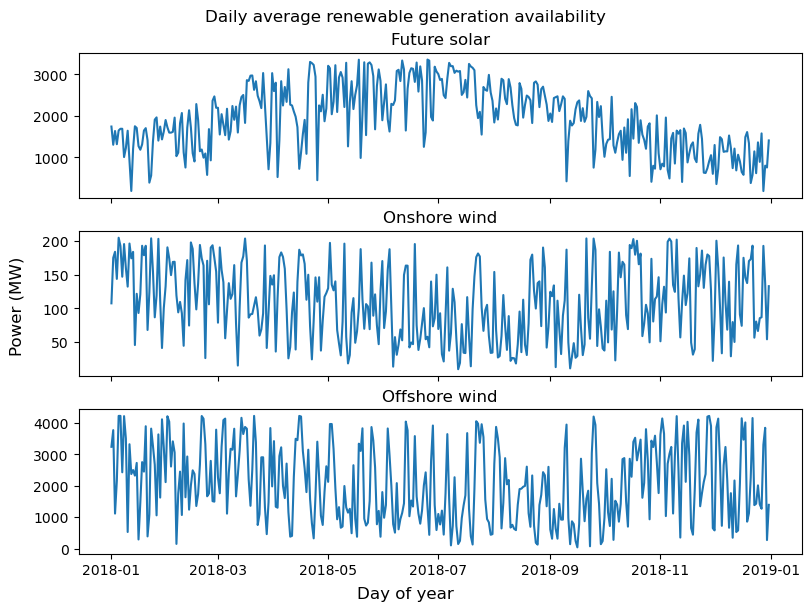

In [9]:
# Aggregate renewable generation
genmax_profile_future_solar = genmax_profile_vre.loc[:,
                                                     genmax_profile_vre.columns.str.contains('FutSol')]
genmax_sum_future_solar = genmax_profile_future_solar.sum(axis=1)
genmax_profile_onshore_wind = genmax_profile_vre.loc[:,
                                                     genmax_profile_vre.columns.str.contains('OnWind')]
genmax_sum_onshore_wind = genmax_profile_onshore_wind.sum(axis=1)
genmax_profile_offshore_wind = genmax_profile_vre.loc[:,
                                                      genmax_profile_vre.columns.str.contains('OffWind')]
genmax_sum_offshore_wind = genmax_profile_offshore_wind.sum(axis=1)

# Plot generation renewable availability
fig, axs = plt.subplots(3, 1, figsize=(8, 6),
                        sharex='all', layout='constrained')
axs[0].plot(genmax_sum_future_solar.resample('D').mean(), label='Future solar')
axs[1].plot(genmax_sum_onshore_wind.resample('D').mean(), label='Onshore wind')
axs[2].plot(genmax_sum_offshore_wind.resample('D').mean(), label='Offshore wind')

titles = ['Future solar', 'Onshore wind', 'Offshore wind']

for i, ax in enumerate(axs):
    ax.set_title(titles[i])

fig.supxlabel('Day of year')
fig.supylabel('Power (MW)')
fig.suptitle('Daily average renewable generation availability')


In [10]:
# Update load profile for electrification
res_building_data_dir = os.path.join(data_dir, 'load', 'residential_building')
print('Residential buildings data directory: {}'.format(res_building_data_dir))

com_building_data_dir = os.path.join(data_dir, 'load', 'commercial_building')
print('Commercial buildings data directory: {}'.format(com_building_data_dir))

electric_vehicle_data_dir = os.path.join(data_dir, 'load', 'electric_vehicle')
print('Electric vehicle data directory: {}'.format(electric_vehicle_data_dir))

# Read NYS county attributes and county to bus mapping
county_attrs = pd.read_csv(os.path.join(data_dir, 'load', 'county_attributes.csv'))
county_2_bus = pd.read_csv(os.path.join(data_dir, 'load', 'county_2_bus.csv'))

electrification_dict = {
    'res_building': {
        'data_dir': res_building_data_dir,
        'upgrade_id': 10,
        'scaling_factor': 0.3
    },
    'com_building': {
        'data_dir': com_building_data_dir,
        'upgrade_id': 18,
        'scaling_factor': 0.3
    },
    'electric_vehicle': {
        'data_dir': electric_vehicle_data_dir,
        'upgrade_id': 0,
        'scaling_factor': 0.3
    }
}

electrification_dict = ng_run.read_electrification_data(electrification_dict,
                                                        county_attrs,
                                                        county_2_bus)

res_building_profile = electrification_dict['res_building']['load_change'] * \
    electrification_dict['res_building']['scaling_factor']
com_building_profile = electrification_dict['com_building']['load_change'] * \
    electrification_dict['com_building']['scaling_factor']
electric_vehicle_profile = electrification_dict['electric_vehicle']['load_change'] * \
    electrification_dict['electric_vehicle']['scaling_factor']



Residential buildings data directory: /mnt/Bo_HDD/NYgrid-python/data/load/residential_building
Commercial buildings data directory: /mnt/Bo_HDD/NYgrid-python/data/load/commercial_building
Electric vehicle data directory: /mnt/Bo_HDD/NYgrid-python/data/load/electric_vehicle
Get electrification data for 3 sectors:
['res_building', 'com_building', 'electric_vehicle']
Processing res_building electrification data...
Building load data is not available for county G3600030 Single-Family Attached. Skipping...
Building load data is not available for county G3600170 Single-Family Attached. Skipping...
Building load data is not available for county G3600230 Single-Family Attached. Skipping...
Building load data is not available for county G3600490 Single-Family Attached. Skipping...
Building load data is not available for county G3600510 Single-Family Attached. Skipping...
Building load data is not available for county G3600950 Single-Family Attached. Skipping...
Building load data is not availab

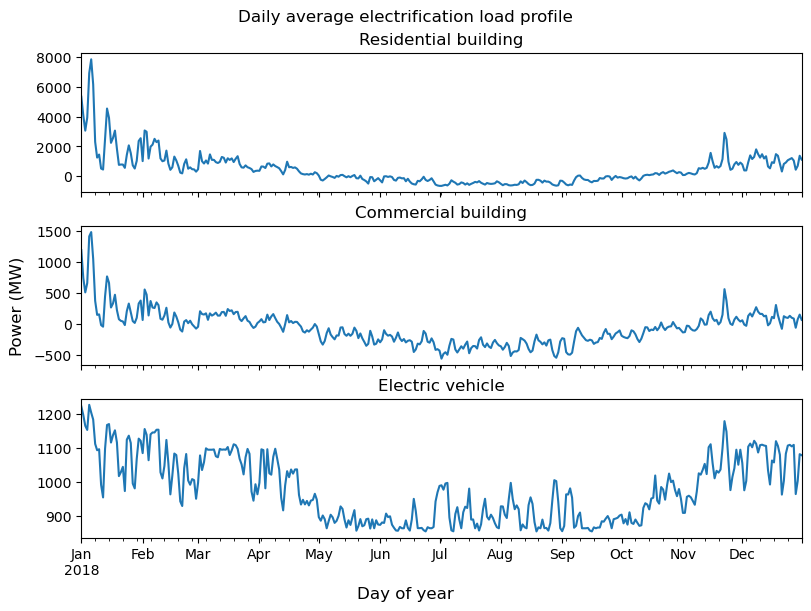

In [11]:
# Plot generation renewable availability
fig, axs = plt.subplots(3, 1, figsize=(8, 6),
                        sharex='all', layout='constrained')

res_building_profile.sum(axis=1).resample('D').mean().plot(ax=axs[0])
com_building_profile.sum(axis=1).resample('D').mean().plot(ax=axs[1])
electric_vehicle_profile.sum(axis=1).resample('D').mean().plot(ax=axs[2])

titles = ['Residential building', 'Commercial building', 'Electric vehicle']

for i, ax in enumerate(axs):
    ax.set_title(titles[i])

fig.supxlabel('Day of year')
fig.supylabel('Power (MW)')
fig.suptitle('Daily average electrification load profile')
plt.show()

In [12]:
load_profile_elec = grid_profile_2030['load_profile'].copy()

for sector, attrs in electrification_dict.items():
    load_change = attrs['load_change'] * attrs['scaling_factor']
    load_profile_elec = load_profile_elec.add(load_change, fill_value=0)

load_profile_elec = load_profile_elec.sort_index(axis=1)
load_profile_elec = load_profile_elec.round(2)
grid_profile_2030['load_profile'] = load_profile_elec

In [13]:
# Create NYGrid object
start_datetime_0 = timestamp_list[0]
end_datetime_0 = start_datetime_0 + timedelta(hours=23)
nygrid_sim_2030 = ng_grid.NYGrid(grid_prop=grid_prop_2030,
                                 start_datetime=start_datetime_0,
                                 end_datetime=end_datetime_0,
                                 verbose=False)
print(f"Number of generators: {nygrid_sim_2030.NG}")
print(f"Number of HVDC lines: {nygrid_sim_2030.NDCL}")
print(f"Number of VRE generators: {nygrid_sim_2030.NVRE}")
print(f"Number of ESR units: {nygrid_sim_2030.NESR}")
print(f"Number of buses and branches: {nygrid_sim_2030.NB} and {nygrid_sim_2030.NBR}")
print(f"Number of loads: {nygrid_sim_2030.NL}")
print(f"Number of time periods: {nygrid_sim_2030.NT}")

Number of generators: 402
Number of HVDC lines: 6
Number of VRE generators: 70
Number of ESR units: 30
Number of buses and branches: 57 and 94
Number of loads: 57
Number of time periods: 24


In [14]:
# Loop through all days
results_list_2030 = []

for d in range(len(timestamp_list)):
    
    # Remove leading hours for the last day
    if d == len(timestamp_list) - 1:
        leading_hours = 0

    # Run OPF for one day (24 hours) plus leading hours
    # The first day is valid, the leading hours are used to dispatch batteries properly
    start_datetime = timestamp_list[d]

    # Read results
    filename = f'nygrid_sim_{sim_name}_{start_datetime.strftime("%Y%m%d%H")}.pkl'
    with open(os.path.join(sim_results_dir_2030, filename), 'rb') as f:
        results = pickle.load(f)

    results_list_2030.append(results)

In [15]:
# Power dispatch of generators by fuel type
# Including ESR, DC line, and VRE
pg_by_fuel_dict_2030 = ng_post.get_pg_by_fuel_from_list(results_list_2030, nygrid_sim_2030)

# ESR results, including discharge and charge power, and SOC
esr_results_2030 = ng_post.get_esr_results_from_list(results_list_2030, nygrid_sim_2030)

# LMP by bus and by zone
# lmp_results_2030 = ng_post.get_lmp_results(results_list_2030, nygrid_sim_2030)

# Branch flow and interface flow results
flow_results_2030 = ng_post.get_flow_results_from_list(results_list_2030, nygrid_sim_2030)

# Costs
cost_results_2030 = ng_post.get_cost_results_from_list(results_list_2030, nygrid_sim_2030)

# Slack variables and penalty costs
slack_results_2030 = ng_post.get_slack_results_from_list(results_list_2030, nygrid_sim_2030)

## Calculate heat input

In [7]:
# 2018 NYCA: 236 thermal generators
thermal_params_2018 = pd.read_csv(os.path.join(
    grid_data_dir_2018, 'thermal_params.csv'))
thermal_params_2018['GEN_NAME'] = thermal_params_2018['NYISO_Name']+thermal_params_2018['ID']

In [14]:
# Save thermal generation profiles for emissions calculation
thermal_fuel_types = ['CC_NG', 'CT_NG', 'CT_FO2', 'CT_KER', 'ST_NG', 'ST_FO6', 'ST_BIT']
thermal_pg_list_2018 = [pg_by_fuel_dict_2018[fuel] for fuel in thermal_fuel_types]
thermal_pg_2018Baseline = pd.concat(thermal_pg_list_2018, axis=1)
thermal_pg_2018Baseline = thermal_pg_2018Baseline.sort_index(axis=1)

# Order the columns
thermal_pg_2018Baseline = thermal_pg_2018Baseline[thermal_params_2018['GEN_NAME']]

# Save to csv
thermal_pg_2018Baseline.to_csv(os.path.join(results_dir, sim_name,
                                            f'thermal_pg_{sim_name}.csv'))

# Calculate heat input from power generation
heat_input_2018Baseline = ng_post.thermal_pg_2_heat_input(thermal_pg_2018Baseline, 
                                                          thermal_params_2018)

# Order the columns
heat_input_2018Baseline = heat_input_2018Baseline[thermal_params_2018['GEN_NAME']]

# Save to csv
heat_input_2018Baseline.to_csv(os.path.join(results_dir, sim_name,
                                            f'heat_input_{sim_name}.csv'))

# Save load profile for emissions calculation
load_profile_2018Baseline = grid_profile_2018['load_profile']
load_profile_2018Baseline.to_csv(os.path.join(results_dir, sim_name,
                                              f'load_profile_{sim_name}.csv'))

In [ ]:
# Save thermal generation profiles for emissions calculation
thermal_fuel_types = ['Combustion Turbine', 'Combined Cycle', 
                      'Internal Combustion', 'Steam Turbine', 'Jet Engine']
thermal_pg_list_2030 = [pg_by_fuel_dict_2030[fuel] for fuel in thermal_fuel_types]
thermal_pg_2030CLCPA = pd.concat(thermal_pg_list_2030, axis=1)
thermal_pg_2030CLCPA = thermal_pg_2030CLCPA.sort_index(axis=1)

# Save to csv
thermal_pg_2030CLCPA.to_csv(os.path.join(results_dir, 'thermal_pg_2030CLCPA_0.3.csv'))

# Calculate heat input from power generation
heat_input_2030CLCPA = ng_post.thermal_pg_2_heat_input(thermal_pg_2030CLCPA, thermal_params_2030)

# Save to csv
heat_input_2030CLCPA.to_csv(os.path.join(results_dir, 'heat_input_2030CLCPA_0.3.csv'))

# Save load profile for emissions calculation
load_profile_2030CLCPA = grid_profile_2030['load_profile']
load_profile_2030CLCPA.to_csv(os.path.join(results_dir, 'load_profile_2030CLCPA_0.3.csv'))

## Plotting

In [18]:
if not os.path.exists(os.path.join(fig_dir, 'thermal_pg')):
    os.makedirs(os.path.join(fig_dir, 'thermal_pg'))


In [19]:
# Representative weeks
season_list = ['Winter', 'Spring', 'Summer', 'Autumn']

winter_week = ['2018-01-01', '2018-01-07']
spring_week = ['2018-04-02', '2018-04-08']
summer_week = ['2018-07-02', '2018-07-08']
autumn_week = ['2018-10-01', '2018-10-07']

week_list = [winter_week, spring_week, summer_week, autumn_week]

### 1. Power generation by fuel type

Text(0.5, 0.98, 'Total generation by fuel type')

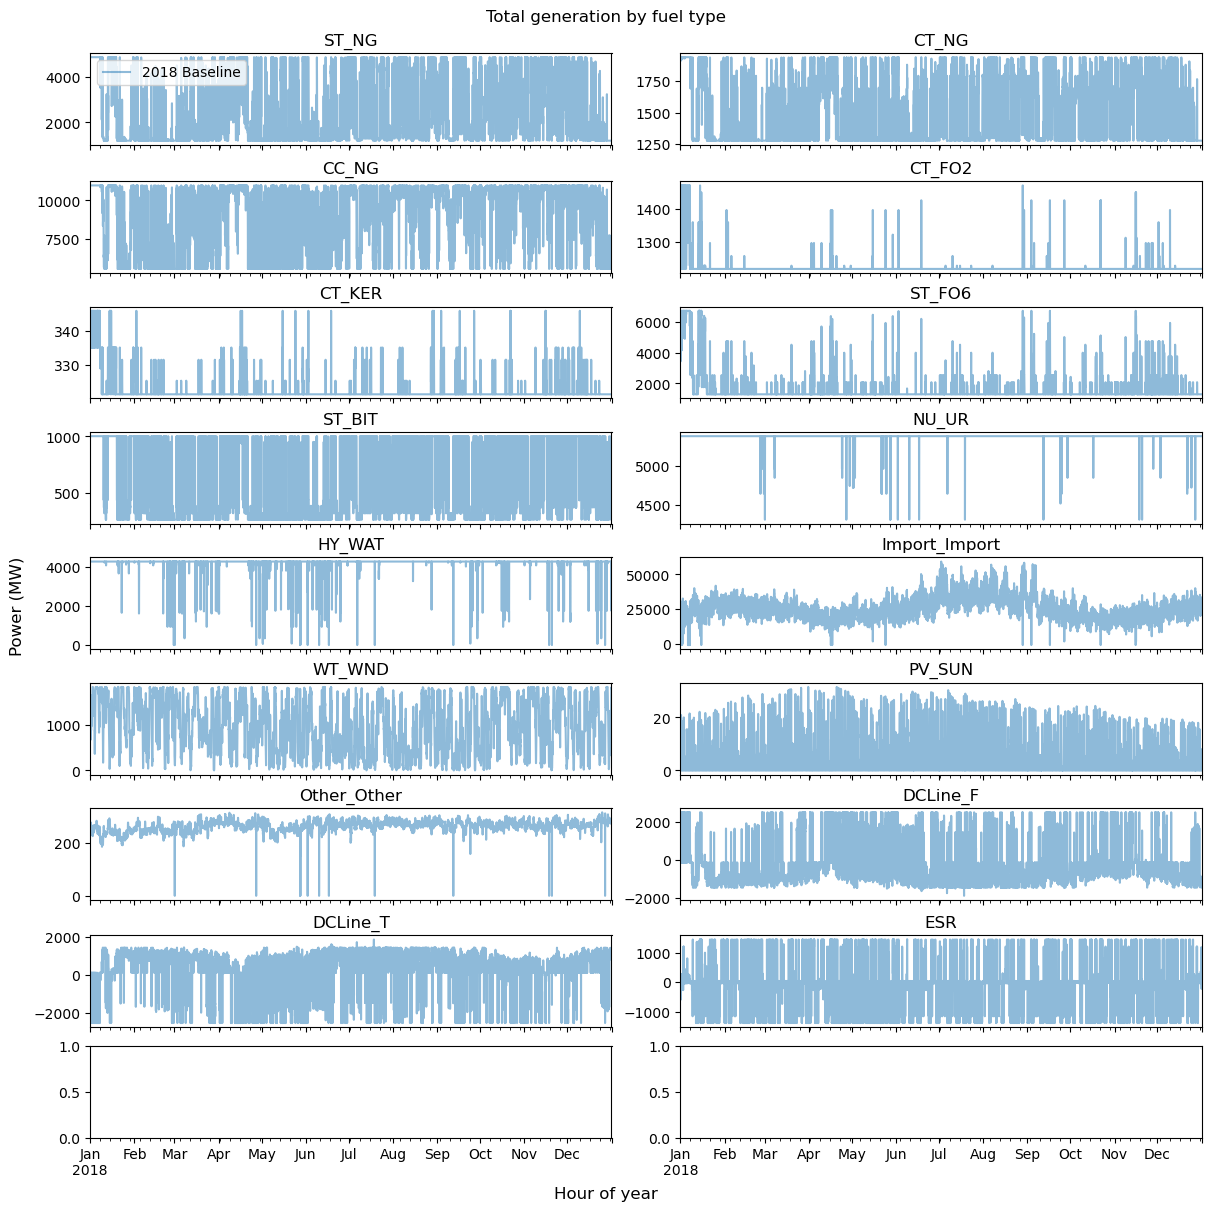

In [20]:
fig, axs = plt.subplots(len(pg_by_fuel_dict_2018)//2+1, 2, figsize=(12, 12),
                        layout='constrained', sharex=True)

# 2018 Baseline
pg_by_fuel_sum_2018 = dict()

for fuel_type, pg_by_fuel in pg_by_fuel_dict_2018.items():
    pg_by_fuel_sum_2018[fuel_type] = pg_by_fuel.sum(axis=1)

# Convert to DataFrame
pg_by_fuel_sum_2018 = pd.DataFrame(pg_by_fuel_sum_2018,
                                   index=pg_by_fuel_dict_2018['CC_NG'].index)

for i, fuel_type in enumerate(pg_by_fuel_sum_2018.columns):
    ax = axs.flatten()[i]
    pg_by_fuel_sum_2018[fuel_type].plot(ax=ax, alpha=0.5, color='tab:blue',
                                        label='2018 Baseline')
    
    ax.set_title(fuel_type)
    if i == 0:
        ax.legend()

fig.supxlabel('Hour of year')
fig.supylabel('Power (MW)')
fig.suptitle('Total generation by fuel type')

In [24]:
bus_prop = nygrid_sim_2018.grid_prop['bus_prop']
bus_zone_dict = bus_prop.set_index('BUS_I')['BUS_ZONE'].to_dict()

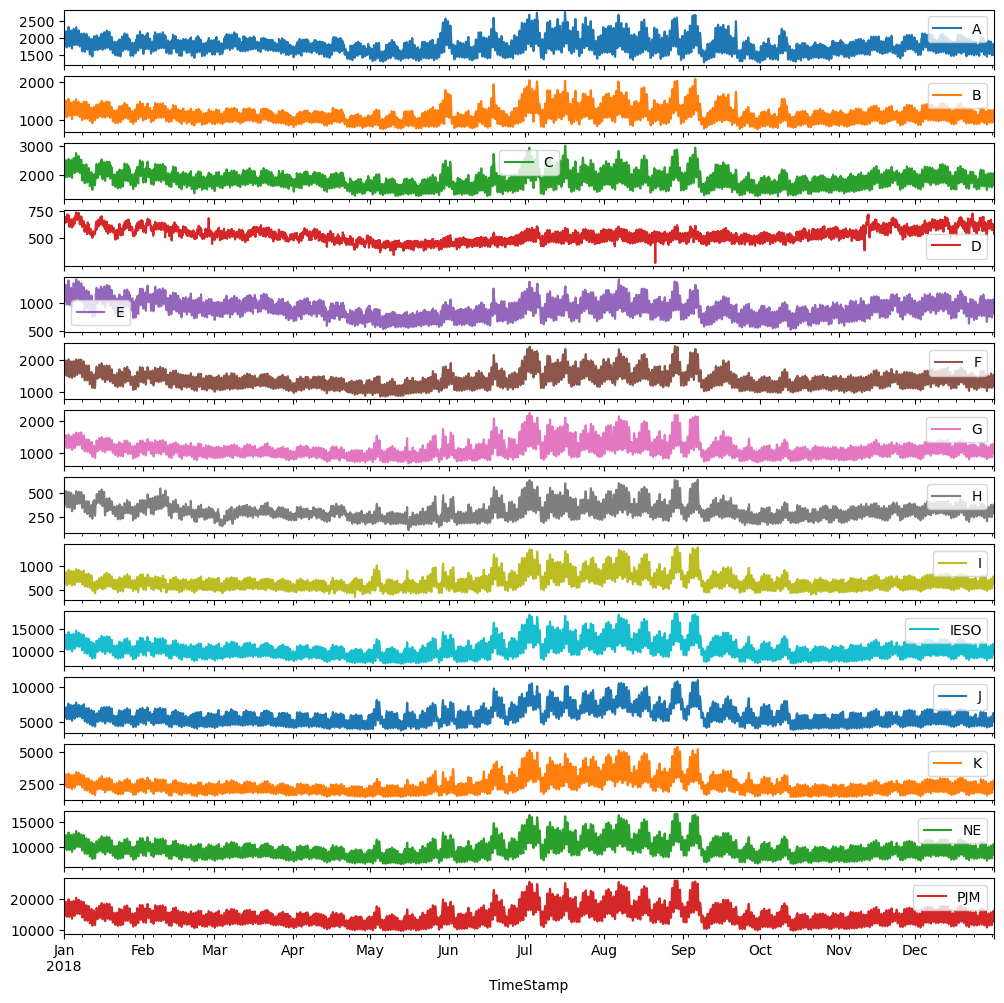

In [29]:
load_profile_by_zone_2018 = load_profile_2018Baseline.groupby(bus_zone_dict, axis=1).sum()
load_profile_by_zone_2018.plot(subplots=True, figsize=(12, 12),
                                 sharex=True)
plt.show()

In [33]:
load_profile_external = load_profile_by_zone_2018[['NE','PJM','IESO']]
load_profile_external_sum = load_profile_external.sum(axis=1)

In [43]:
genmax_profile = grid_profile_2018['genmax_profile']
col_ext = [col for col in genmax_profile.columns if 'NE' in col or 'PJM' in col or 'IESO' in col]
genmax_profile_external = genmax_profile[col_ext]
genmax_profile_external_sum = genmax_profile_external.sum(axis=1)

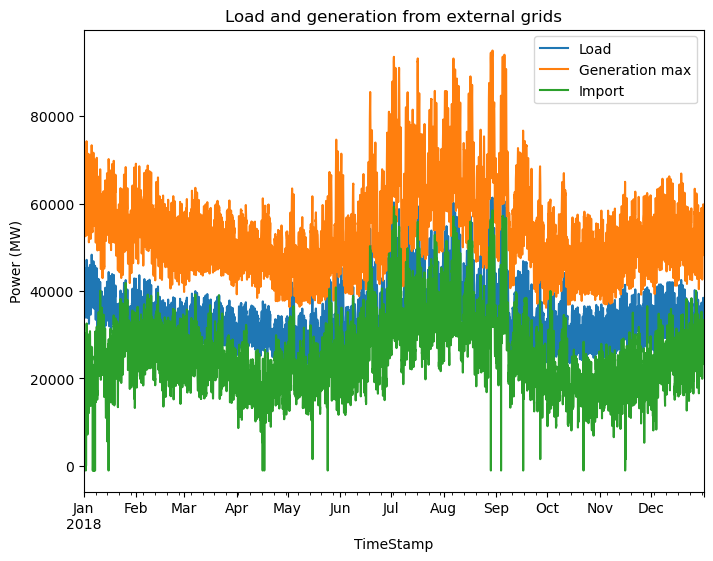

In [45]:
fig, ax = plt.subplots(figsize=(8, 6))
load_profile_external_sum.plot(ax=ax, label='Load')
genmax_profile_external_sum.plot(ax=ax, label='Generation max')
pg_by_fuel_sum_2018['Import_Import'].plot(ax=ax, label='Import')
ax.set_ylabel('Power (MW)')
ax.set_title('Load and generation from external grids')
ax.legend()
plt.show()

<Axes: >

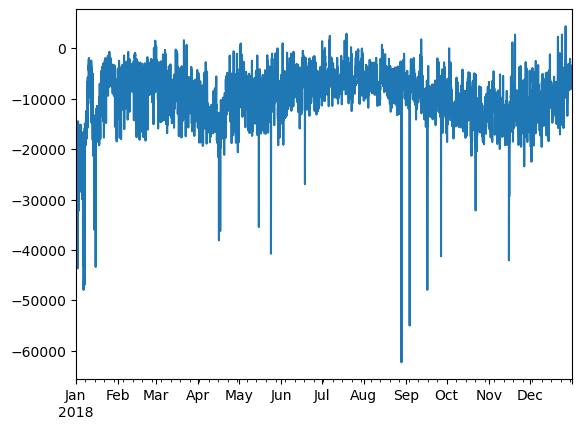

In [34]:
net_import = pg_by_fuel_sum_2018['Import_Import'] - load_profile_external_sum
net_import.plot()

Text(0.5, 0.98, 'Total generation by fuel type')

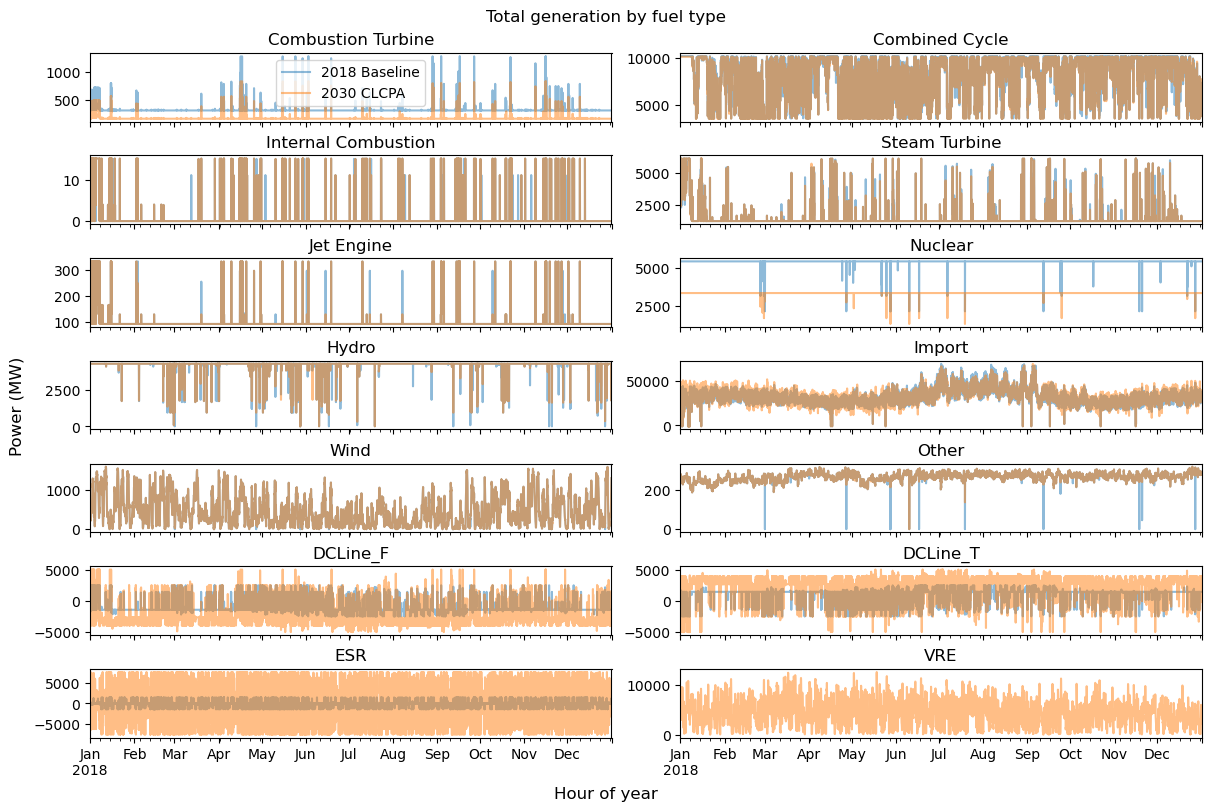

In [20]:
fig, axs = plt.subplots(len(pg_by_fuel_dict_2018)//2+1, 2, figsize=(12, 8),
                        layout='constrained', sharex=True)

# 2018 Baseline
pg_by_fuel_sum_2018 = dict()

for fuel_type, pg_by_fuel in pg_by_fuel_dict_2018.items():
    pg_by_fuel_sum_2018[fuel_type] = pg_by_fuel.sum(axis=1)

# Convert to DataFrame
pg_by_fuel_sum_2018 = pd.DataFrame(pg_by_fuel_sum_2018,
                                   index=pg_by_fuel_dict_2018['Wind'].index)

for i, fuel_type in enumerate(pg_by_fuel_sum_2018.columns):
    ax = axs.flatten()[i]
    pg_by_fuel_sum_2018[fuel_type].plot(ax=ax, alpha=0.5, color='tab:blue',
                                        label='2018 Baseline')

# 2030 CLCPA
pg_by_fuel_sum_2030 = dict()

for fuel_type, pg_by_fuel in pg_by_fuel_dict_2030.items():
    pg_by_fuel_sum_2030[fuel_type] = pg_by_fuel.sum(axis=1)

# Convert to DataFrame
pg_by_fuel_sum_2030 = pd.DataFrame(pg_by_fuel_sum_2030,
                                   index=pg_by_fuel_dict_2030['Wind'].index)

for i, fuel_type in enumerate(pg_by_fuel_sum_2030.columns):
    ax = axs.flatten()[i]
    pg_by_fuel_sum_2030[fuel_type].plot(ax=ax, alpha=0.5, color='tab:orange',
                                        label='2030 CLCPA')
    ax.set_title(fuel_type)
    if i == 0:
        ax.legend()

fig.supxlabel('Hour of year')
fig.supylabel('Power (MW)')
fig.suptitle('Total generation by fuel type')

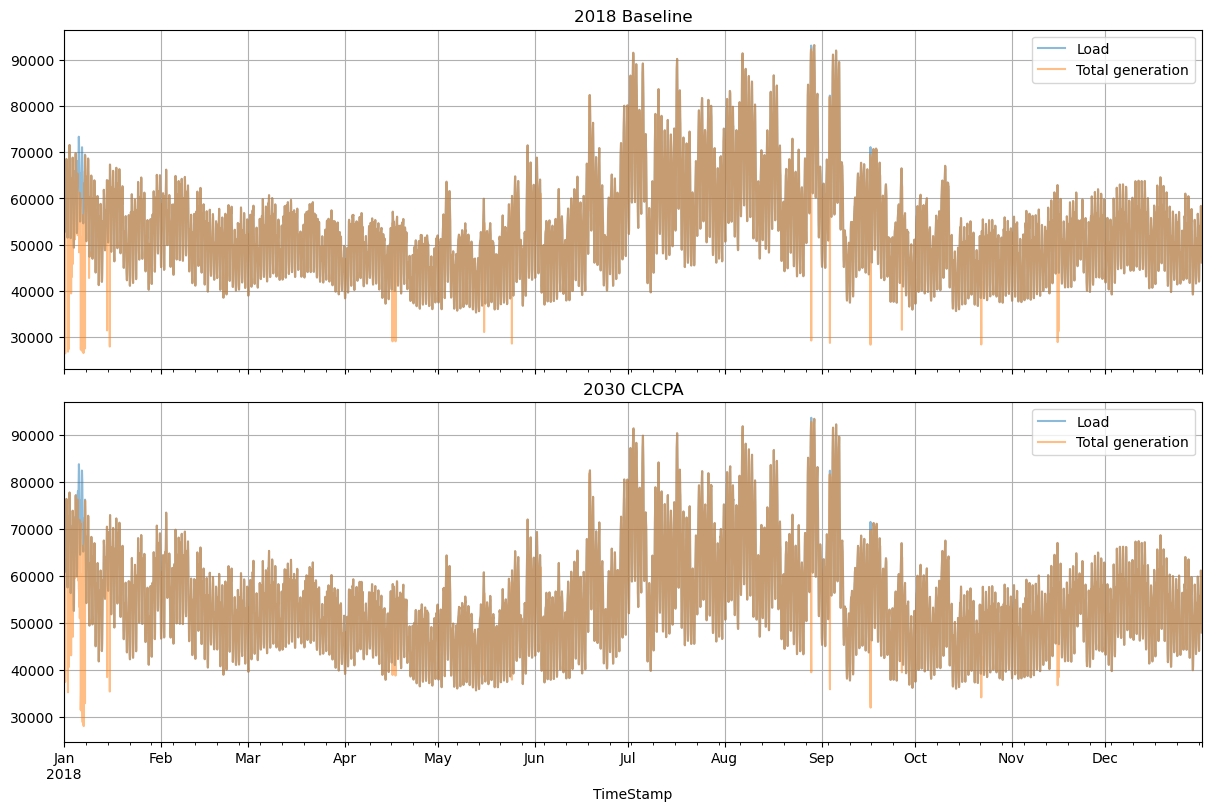

In [21]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True,
                        layout='constrained')
grid_profile_2018['load_profile'].sum(axis=1).plot(ax=axs[0], label='Load', alpha=0.5)
pg_by_fuel_sum_2018.sum(axis=1).plot(ax=axs[0], label='Total generation', alpha=0.5)

grid_profile_2030['load_profile'].sum(axis=1).plot(ax=axs[1], label='Load', alpha=0.5)
pg_by_fuel_sum_2030.sum(axis=1).plot(ax=axs[1], label='Total generation', alpha=0.5)

titles = ['2018 Baseline', '2030 CLCPA']
for ax in axs.flatten():
    ax.legend()
    ax.set_title(titles.pop(0))
    ax.grid()

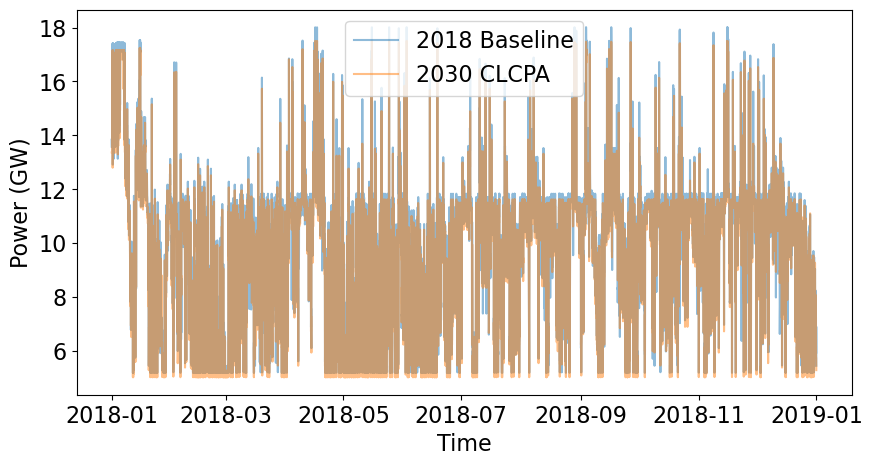

In [22]:
# Total thermal generation
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(thermal_pg_2018Baseline.sum(axis=1)/1e3, alpha=0.5, color='tab:blue',
        label='2018 Baseline')
ax.plot(thermal_pg_2030CLCPA.sum(axis=1)/1e3, alpha=0.5, color='tab:orange',
        label='2030 CLCPA')

ax.set_ylabel('Power (GW)', fontsize=16)
ax.set_xlabel('Time', fontsize=16)
ax.legend(fontsize=16)
ax.tick_params(labelsize=16)
# fig.savefig(os.path.join(fig_dir, f'total_thermal_gen_year.png'), 
#             dpi=600, bbox_inches='tight', format='png')
# fig.savefig(os.path.join(fig_dir, f'total_thermal_gen_year.svg'), 
#             bbox_inches='tight', format='svg')


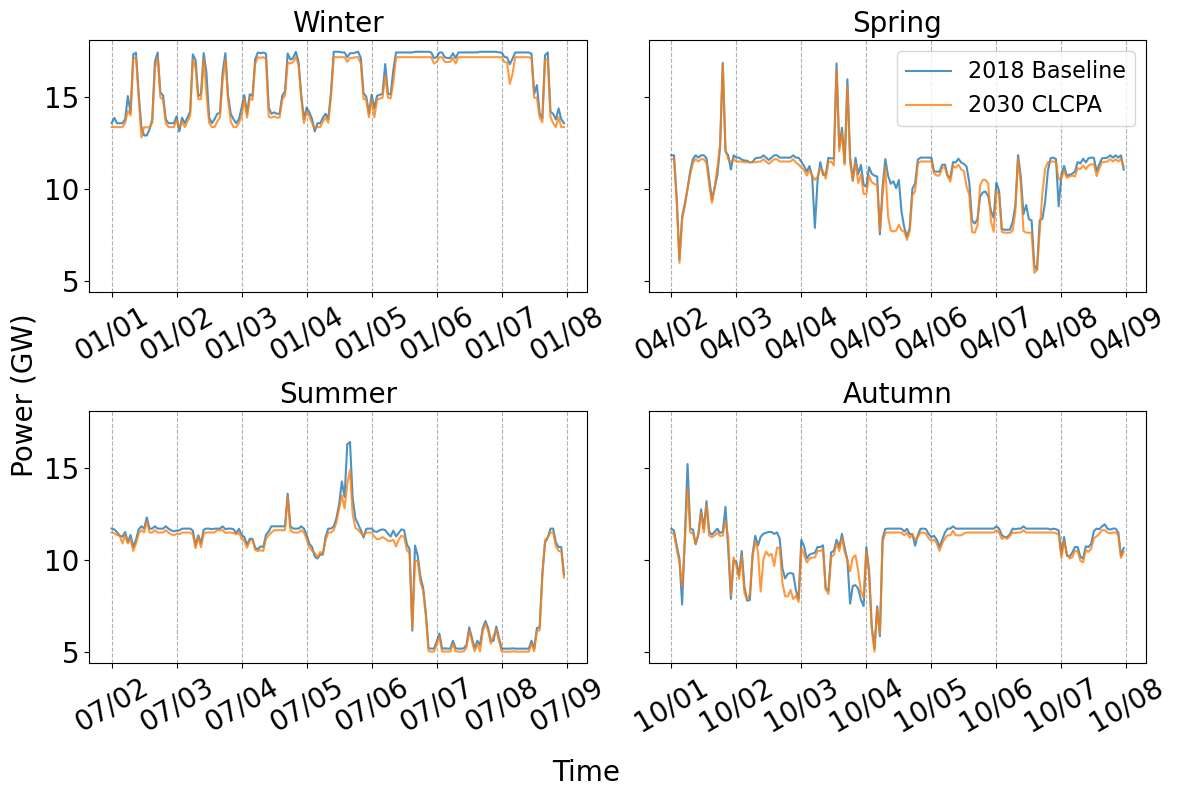

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8),
                        sharex=False, sharey=True)

for i in range(4):
    ax = axs.flatten()[i]
    
    ax.plot(1/1e3*thermal_pg_2018Baseline.sum(axis=1).loc[week_list[i][0]:week_list[i][1]], 
            alpha=0.8, color='tab:blue', label='2018 Baseline')
    ax.plot(1/1e3*thermal_pg_2030CLCPA.sum(axis=1).loc[week_list[i][0]:week_list[i][1]], 
            alpha=0.8, color='tab:orange', label='2030 CLCPA')

    # Formatting
    ax.xaxis.set_major_formatter(mdates.DateFormatter(r'%m/%d'))
    # ax.set_ylim(0, 30)
    ax.tick_params(axis='x', rotation=30)
    ax.set_title(season_list[i], fontsize=20)
    ax.grid(axis='x', linestyle='--')
    ax.tick_params(axis='both', which='major', labelsize=20)
    if i == 1:
            ax.legend(fontsize=16, loc='upper right')


fig.supxlabel('Time', fontsize=20)
fig.supylabel('Power (GW)', fontsize=20)
# title = 'Total thermal generation in NYS'
# fig.suptitle(title, fontsize=24)
plt.tight_layout()
# fig.savefig(os.path.join(fig_dir, f'total_thermal_gen_rep_weeks.png'), 
#             dpi=600, bbox_inches='tight', format='png')
# fig.savefig(os.path.join(fig_dir, f'total_thermal_gen_rep_weeks.svg'), 
#             bbox_inches='tight', format='svg')

### 2. Energy storage

### 3. LMP

In [24]:
# fig, axs = plt.subplots(7, 2, figsize=(12, 12), 
#                         sharex='all', sharey='all')

# for i, ax in enumerate(axs.flat):
#     lmp_results_2018['LMP_by_zone'].iloc[:, i].plot(ax=ax, label='2018 Baseline', alpha=0.5)
#     lmp_results_2030['LMP_by_zone'].iloc[:, i].plot(ax=ax, label='2030 CLCPA', alpha=0.5)
#     ax.set_title(lmp_results_2018['LMP_by_zone'].columns[i])
#     ax.legend()

# fig.tight_layout()

In [25]:
# fig, axs = plt.subplots(2, 2, figsize=(12, 8),
#                         sharex=False, sharey=True)

# for i in range(4):
#     ax = axs.flatten()[i]
    
#     ax.plot(lmp_results_2018['LMP_by_zone'].mean(axis=1).loc[week_list[i][0]:week_list[i][1]], 
#             alpha=0.5, label='2018 Baseline')
#     ax.plot(lmp_results_2030['LMP_by_zone'].mean(axis=1).loc[week_list[i][0]:week_list[i][1]], 
#             alpha=0.5, label='2030 CLCPA')

#     # Formatting
#     ax.xaxis.set_major_formatter(mdates.DateFormatter(r'%m/%d'))
#     # ax.set_ylim(0, 30)
#     ax.tick_params(axis='x', rotation=30)
#     ax.set_title(season_list[i], fontsize=20)
#     ax.grid(axis='x', linestyle='--')
#     ax.tick_params(axis='both', which='major', labelsize=20)
#     if i == 1:
#             ax.legend(fontsize=16, loc='upper right')


# fig.supxlabel('Time', fontsize=20)
# fig.supylabel('LMP ($/MWh)', fontsize=20)
# # title = 'Total thermal generation in NYS'
# # fig.suptitle(title, fontsize=24)
# plt.tight_layout()
# # fig.savefig(os.path.join(fig_dir, f'total_thermal_gen_rep_weeks.png'), 
# #             dpi=600, bbox_inches='tight', format='png')
# # fig.savefig(os.path.join(fig_dir, f'total_thermal_gen_rep_weeks.svg'), 
# #             bbox_inches='tight', format='svg')